<a href="https://colab.research.google.com/github/seisbench/seisbench/blob/main/examples/03d_catalog_seisbench_pyocto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench and the other required dependencies. If all dependencies are already installed on your machine, you can skip this.*

In [12]:
!pip install seisbench pyocto             # to install the package of seisbench and pyocto


*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [13]:
try:
    import obspy                                   # import seismological libraries
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

# Creating a catalog - From waveforms to events

This model shows how to use [SeisBench](https://github.com/seisbench/seisbench) and the [PyOcto associator](https://github.com/yetinam/pyocto) to create an earthquake catalog from raw waveforms. First, we will download raw waveforms and station metadata through FDSN. Second, we use an PhaseNet model in SeisBench to obtain phase arrival picks. Third, we use the PyOcto associator to associate the picks to events. We visualize the results.

In [14]:

#Import all necessary libraries and modules:

import obspy           # For seismology data (retrieval, waveform, event info)
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import numpy as np             # numpy, Counter: Numerical and frequency analysis.

from collections import Counter
import matplotlib.pyplot as plt       # matplotlib, seaborn: For plotting results.
import seaborn as sns
import torch                      # to access Octo seismic event catalog

import pyocto                    # to access Octo seismic event catalog
import seisbench.models as sbm          # For loading ML models like PhaseNet, EQTransformer

sns.set(font_scale=1.2)
sns.set_style("ticks")

## Obtaining the data

We download waveform data for 12 hours from the CX network in Northern Chile. We use the 5rd April 2014, about 72 hours after the Mw 8.1 Iquique mainshock late on 1st April 2014. Therefore, we expect to see high levels of aftershock activity. In addition to the waveform data, we download the station inventories. Downloading the data might take a few minutes.

In [15]:
# download 12 hours of waveform data from the CX network using the GFZ FDSN client.
# The waveform data is stored in stream, and the station metadata in inv


client = Client("GFZ")           # Use GFZ (German Research Centre for Geosciences) as FDSN data provider

# Define start and end time for waveform download
t0 = UTCDateTime("2014/04/05 00:00:00")                        # Start time
t1 = t0 + 12 * 60 * 60                                         # End time = start + 12 hours

# Optional: You could use 24 hours instead, but this requires more memory
# t1 = t0 + 24 * 60 * 60   # Full day, requires more memory

# Download waveform data from GFZ for network "CX", station "*", all locations and channels starting with "HH"
stream = client.get_waveforms(network="CX", station="*", location="*", channel="HH?", starttime=t0, endtime=t1)

# Get station metadata for the same query
inv = client.get_stations(network="CX", station="*", location="*", channel="HH?", starttime=t0, endtime=t1)

## Picking

For this example, we use PhaseNet trained on the INSTANCE dataset from Italy. However, in principal any picker could be used for obtaining the picks with only minimal changes.

**Warning:** This will take some time and requires sufficient main memory. If you are short on memory, reduce the study time in the cell before.

**Note:** We automatically check if CUDA is available and run the model on CUDA in this case. Alternatively, the model runs on CPU.

In [16]:
# Load the PhaseNet model and applies the model to the waveform stream with relatively low pick thresholds (0.05) to allow more picks.

picker = sbm.PhaseNet.from_pretrained("instance")           # Load pretrained PhaseNet model (trained on INSTANCE dataset)

if torch.cuda.is_available():# Check if GPU is available
    picker.cuda()              # Use GPU if available for faster processing

# Run the picker on the waveform stream to identify P and S phases
# batch_size=256: process waveforms in batches
# P_threshold and S_threshold set the minimum probability to accept a pick

# We tuned the thresholds a bit - Feel free to play around with these values
picks = picker.classify(stream, batch_size=256, P_threshold=0.05, S_threshold=0.05).picks
#  PhaseNet is very sensitive due to low thresholds.

Let's have a look at the picks determined by the model.

In [17]:
# Count how many picks were classified as P and S phases.
# Print the total count and a preview of the pick list.

counts = Counter([p.phase for p in picks])                  # Count how many P and S picks were made

# Print summary
print("P picks:", counts["P"], "\t\tS picks:", counts["S"], "\n")  # Output number of P and S picks

# Print all picks: shows station, time, and phase (P or S)
print(picks)

P picks: 9311 		S picks: 5938 

PickList with 15249 entries:

CX.MNMCX.	2014-04-05T00:00:56.600000Z	P
CX.MNMCX.	2014-04-05T00:01:48.900000Z	P
CX.MNMCX.	2014-04-05T00:02:05.900000Z	P
...
CX.PSGCX.	2014-04-05T11:58:36.609999Z	P
CX.PSGCX.	2014-04-05T11:58:43.819999Z	P
CX.PSGCX.	2014-04-05T11:58:58.209999Z	S


## Configuring the associator

We now set up the associator. First, we define a velocity model to use. We go for a homogeneous velocity model. While a crude approximation in a subduction zone, it still gives good association. Check out the [PyOcto documentation](https://pyocto.readthedocs.io/en/latest/pages/velocity_models.html) for details on velocity models and how to use 1D models.

In [18]:
# Create a simple 0D velocity model (constant velocities) for associating P and S picks into seismic events.

velocity_model = pyocto.VelocityModel0D(
      p_velocity=7.0,                     # Assumed P-wave velocity in km/s
    s_velocity=4.0,                     # Assumed S-wave velocity in km/s
    tolerance=2.0,                      # Maximum residual time in seconds for associating picks into events
    association_cutoff_distance=250,   # Max distance (in km) for stations to be grouped into the same event
)


# p_velocity, s_velocity: help estimate distances and origin times.
# tolerance: allows some flexibility in phase arrival times.
# association_cutoff_distance: max spatial distance between picks to consider them from the same event.

Next, we create the associator. We use the `from_area` function, as it will automatically select a local coordinate projection to use for the association. In addition, we set the overlap time (`time_before`), and pick based quality control criteria.

In [19]:
# Create an OctoAssociator object using a geographic area specification.
# The associator clusters phase picks into events based on spatial and temporal criteria.

associator = pyocto.OctoAssociator.from_area(
    lat=(-25, -18),                  # Latitude bounds for the region of interest (Southern Peru/Northern Chile)
    lon=(-71.5, -68),                # Longitude bounds for the region of interest (Andes subduction zone)
    zlim=(0, 200),                   # Depth limits in km for event association (0 to 200 km deep)
    time_before=300,                # Look-back time window in seconds before each pick for possible event associations
    velocity_model=velocity_model,  # Velocity model used for travel-time predictions (defined earlier)
    n_picks=10,                     # Minimum number of total picks required to form an event
    n_p_and_s_picks=4,              # Minimum number of picks that must include both P and S phases
    )


Lastly, we convert the station information from the obspy inventory to the data frame required for PyOcto.

In [20]:
# Convert Station Inventory to DataFrame
# Convert ObsPy Inventory (station metadata) into a pandas DataFrame format required by PyOcto for associating picks with stations
stations = associator.inventory_to_df(inv)

## Association

We now run the phase association. We use the `associate_seisbench` function that directly takes the output of a SeisBench picking model as input. PyOcto offers further interfaces, for example, to input Pandas data frames. The association will take a moment (up to a few minutes on slower CPUs). The output are two dataframe:

- `events` contains a list of all events with their location and origin times
- `assignments` contains all picks and the event they are associated with

In [21]:
# Run Phase Association with PyOcto that use both the pick information and station metadata
# Run phase association using PyOcto’s built-in method for SeisBench pick format to:
# 1- Estimate the origin time and hypocenter location of each seismic event.
# 2- Associate each pick with a specific event.
# This method links seismic picks into seismic events using clustering & travel time models

events, assignments = associator.associate_seisbench(picks, stations)

The events currently only contain locations in a local coordinate system. Let's transform it back to latitude and longitude before inspecting the events.

In [22]:
# Convert local event coordinates (e.g., in meters) back to geographic coordinates (latitude/longitude)

associator.transform_events(events);

## Visualizing the catalog

Let's have a look at the list of events. Every event is listed with its time, local coordinates (x, y, z), the number of picks and the latitude, longitude and depth. Within the 12 hours of the example, we found over 400 event, on average one event every 100 seconds.

In [23]:
# Visualizing the catalog and displaying the DataFrame events that was generated by the association process in Cell 10 and converted to lat/lon in Cell 11

events

,idx,time,x,y,z,picks,latitude,longitude,depth
0,0,1.396656e+09,-128.157123,170.282269,30.859375,17,-19.957735,-70.974262,30.859375
1,1,1.396656e+09,-102.091267,200.603081,1.953125,14,-19.685422,-70.723621,1.953125
2,2,1.396656e+09,-19.549392,199.087040,77.734375,10,-19.701660,-69.936464,77.734375
3,3,1.396656e+09,-104.987474,95.996280,0.390625,10,-20.630028,-70.757282,0.390625
4,4,1.396656e+09,-119.468504,73.255672,24.609375,13,-20.834521,-70.897745,24.609375
...,...,...,...,...,...,...,...,...,...
444,444,1.396699e+09,-81.817824,168.008208,0.390625,12,-19.980776,-70.531732,0.390625
445,445,1.396699e+09,-26.789907,174.830391,51.171875,17,-19.920689,-70.005874,51.171875
446,446,1.396699e+09,-35.478526,161.944046,47.265625,24,-20.036952,-70.089108,47.265625
447,447,1.396699e+09,-131.053329,131.623234,25.390625,16,-20.306663,-71.004707,25.390625


We can also plot the catalog. Conveniently, we already have a local transverse mercator projection available, so no need for further thought in the plotting here. We use the `scatter` function and encode the depth of the events using color. The plot nicely resolves the intense shallow aftershock activity. It also shows the seismicity along the Slap (West-East dipping).

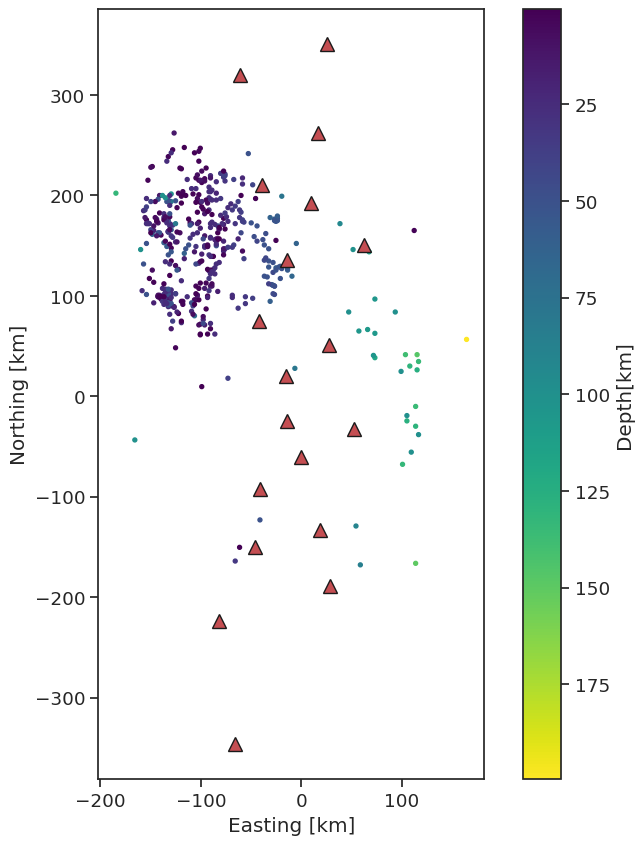

In [24]:
# Create a new figure with specified size (10x10 inches)
fig = plt.figure(figsize=(10, 10))

# Add a subplot to the figure (1x1 grid, position 1)
ax = fig.add_subplot(111)

# Set the aspect ratio of the plot to "equal" so that units on both axes are equally scaled
ax.set_aspect("equal")

# Create a scatter plot of earthquake events
# x and y coordinates are taken from the projected event positions
# Color of each point represents the depth ('z') of the earthquake
# Size of each point is 8, and the color map used is 'viridis' (dark = shallow, bright = deep)
cb = ax.scatter(events["x"], events["y"], c=events["z"], s=8, cmap="viridis")

# Add a colorbar to the figure, linked to the scatter plot
cbar = fig.colorbar(cb)

# Reverse the colorbar so that shallow events (small depth values) are on top
cbar.ax.set_ylim(cbar.ax.get_ylim()[::-1])

# Label the colorbar to indicate it shows event depth in kilometers
cbar.set_label("Depth [km]")

# Plot the station locations using red upward-pointing triangles
# Size of each triangle is 10, with a black edge (mec = marker edge color)
ax.plot(stations["x"], stations["y"], "r^", ms=10, mew=1, mec="k")

# Label the x-axis as Easting (in kilometers)
ax.set_xlabel("Easting [km]")

# Label the y-axis as Northing (in kilometers)
ax.set_ylabel("Northing [km]")

# Display the full plot
plt.show()

# Output : #  Many earthquakes are clustered in the upper-left region.
           # Most earthquakes are shallow (dark-colored).
           # The stations are spread across the region, helping record the events.

As a last check, we manually inspect some events. The code block below selects a random event and plots the waveforms, together with the P (solid black lines) and S (dashed black lines). The x axis denotes the time, the y axis the distance between station and estimated event location. Therefore, we should see roughly a hyperbolic moveout. Run the cell a few times to see a few example events.

Event information
idx          3.730000e+02
time         1.396693e+09
x           -1.527749e+02
y            1.725563e+02
z            2.539062e+01
picks        1.700000e+01
latitude    -1.993542e+01
longitude   -7.120919e+01
depth        2.539062e+01
Name: 373, dtype: float64


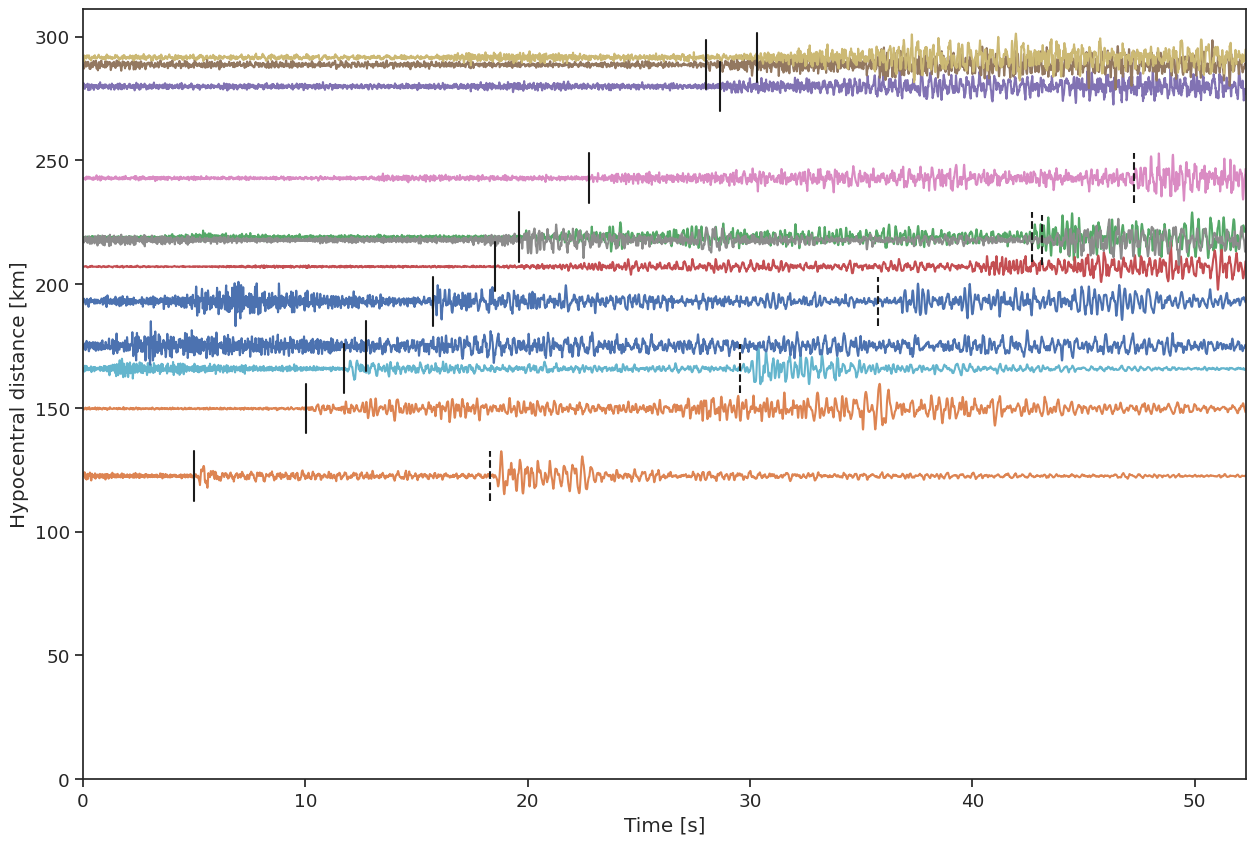

In [26]:
# Select a random event and plots the waveforms

# Pick a random event index from the list of associated events
event_idx = np.random.choice(events["idx"])

# Select all picks that were assigned to this specific event
event_picks = [picks[i] for i in assignments[assignments["event_idx"] == event_idx]["pick_idx"]]

# Extract the event metadata (coordinates, time, etc.)
event = events[events["idx"] == event_idx].iloc[0]

# Create a dictionary mapping station IDs to their (x, y) coordinates for easy lookup
station_dict = {station: (x, y) for station, x, y in zip(stations["id"], stations["x"], stations["y"])}

# Find the earliest and latest pick time for this event
first, last = min(pick.peak_time for pick in event_picks), max(pick.peak_time for pick in event_picks)

# Create an empty ObsPy Stream to hold waveform traces
sub = obspy.Stream()

# Loop over all unique station IDs in the event picks
for station in np.unique([pick.trace_id for pick in event_picks]):
    # Select the vertical component (HHZ) waveform from the original stream
    sub.append(stream.select(station=station[3:-1], channel="HHZ")[0])

# Slice the waveform data to a time window around the event (±5s from pick times)
sub = sub.slice(first - 5, last + 5)

# Copy, detrend, and high-pass filter the waveforms to remove noise and offsets
sub = sub.copy()
sub.detrend()
sub.filter("highpass", freq=2)

# Set up the plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

# Plot each waveform trace
for i, trace in enumerate(sub):
    normed = trace.data - np.mean(trace.data)                   # Remove DC offset
    normed = normed / np.max(np.abs(normed))                    # Normalize amplitude
    station_x, station_y = station_dict[trace.id[:-4]]          # Get station location
    # Calculate the hypocentral distance from station to event
    y = np.sqrt((station_x - event["x"]) ** 2 + (station_y - event["y"]) ** 2 + event["z"] ** 2)
    # Plot the waveform trace, shifted vertically by its hypocentral distance
    ax.plot(trace.times(), 10 * normed + y)

# Overlay P and S picks as vertical lines at their time and distance
for pick in event_picks:
    station_x, station_y = station_dict[pick.trace_id]
    y = np.sqrt((station_x - event["x"]) ** 2 + (station_y - event["y"]) ** 2 + event["z"] ** 2)
    x = pick.peak_time - trace.stats.starttime                   # Pick time relative to trace start
    ls = '-' if pick.phase == "P" else '--'                     # Line style: solid for P, dashed for S
    ax.plot([x, x], [y - 10, y + 10], 'k', ls=ls)               # Plot pick as vertical line

# Configure plot appearance
ax.set_ylim(0)                                                 # Set lower limit of y-axis
ax.set_xlim(0, np.max(trace.times()))                          # Set x-axis from 0 to max time
ax.set_ylabel("Hypocentral distance [km]")                     # Label y-axis
ax.set_xlabel("Time [s]")                                      # Label x-axis

# Print out basic event information in the notebook
print("Event information")
print(event)

# Output: One seismic event, recorded at multiple stations (as seismograms/traces).
# Each colored waveform is a seismogram from a station that detected the earthquake
           # The black vertical lines show the detected seismic phases:
                         # Solid lines = P-wave arrivals (faster, arrive first)
                         # Dashed lines = S-wave arrivals (slower, arrive later)
# Waveforms from stations closer to the event appear lower on the plot.
# The pattern of wave arrival times increasing with distance, forming a hyperbolic moveout
            #

## Closing remarks

In this tutorial, we saw how to quickly generate an event catalog from raw seismic waveforms and their metadata using SeisBench and the PyOcto associator.

- Both the picker and the associator have several tuning parameters. We tuned these parameters loosely, but we would like to make the reader aware that these parameters can have strong influence on the number of picks and events, the number of false positives, and the runtime performance of the associator. To learn more about PyOcto, check out the [Github repository](https://github.com/yetinam/pyocto) and the [documentation](https://pyocto.readthedocs.io/en/latest/index.html).
- While PyOcto outputs locations, these are only preliminary. They will usually not be as accurate as locations determined with dedicated tools, such as NonLinLoc. It is highly recommended to follow-up the event detection with a dedicated location procedure.